In [1]:
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth vllm
!pip install triton==3.1.0
!pip install -U pynvml

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 2.1 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_Token")

In [3]:
# CELL 1: Force Single GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "google/txgemma-2b-predict"

quant_config = BitsAndBytesConfig(
    load_in_4bit            = True,
    bnb_4bit_quant_type     = "nf4",
    bnb_4bit_compute_dtype  = torch.float16,
    llm_int8_enable_fp32_cpu_offload = False,
)

tokenizer = AutoTokenizer.from_pretrained(model_id,token=secret_value_0)  # loads tokenizer.json, tokenizer.model,
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token = secret_value_0,
    quantization_config = quant_config,
    device_map          = {'':0},      #Use one GPU
    torch_dtype         = torch.float16,
    attn_implementation = "eager",     #Google’s preferred attention implementation for this model
)

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

2025-04-27 21:44:59.594995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745790299.789477      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745790299.849730      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [5]:
import re
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

def get_trialbench(split="train"):
    raw = load_dataset(
        "json",
        data_files="/kaggle/input/txgemma-datasets-trialbench-adverse-event/txgemma_datasets_trialbench_adverse-event-rate-prediction_train.jsonl",
        split=split,
    )
    # Concatenate the system prompt and the user text into one string
    def fmt(x):
        return {
            "prompt": SYSTEM_PROMPT.strip() + "\n\n" + x["input_text"].strip(),
            "answer": x["output_text"].strip(),
        }
    return raw.map(fmt)

dataset = get_trialbench()

def extract_xml_answer(text: str) -> str:
    # exactly as before
    answer = text.split("<answer>")[-1].split("</answer>")[0]
    return answer.strip()

def count_xml(text: str) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:        count += 0.125
    if text.count("\n</reasoning>\n") == 1:     count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1]) * 0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1) * 0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    # completions is List[str]
    return [count_xml(c) for c in completions]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    return [0.5 if re.match(pattern, c, re.DOTALL) else 0.0 for c in completions]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    return [0.5 if re.search(pattern, c, re.DOTALL) else 0.0 for c in completions]

def int_reward_func(completions, **kwargs) -> list[float]:
    extracted = [extract_xml_answer(c) for c in completions]
    return [0.5 if r.isdigit() else 0.0 for r in extracted]

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    # `answer` is List[str] of ground-truth
    extracted = [extract_xml_answer(c) for c in completions]
    return [2.0 if r == a else 0.0 for r, a in zip(extracted, answer)]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14368 [00:00<?, ? examples/s]

**Modified Cell with new Training Settings**

In [14]:
from peft import LoraConfig, get_peft_model
from trl  import GRPOConfig, GRPOTrainer
import torch

# 1) Attach LoRA adapters as before
lora_cfg = LoraConfig(
    r              = 16,
    lora_alpha     = 16,
    target_modules = ["gate_proj", "up_proj", "down_proj"],
    bias           = "none",
    task_type      = "CAUSAL_LM",
)
peft_model = get_peft_model(model, lora_cfg)

# 2) Build GRPOConfig tuned for a 2B model
training_args = GRPOConfig(
    use_vllm                    = False,
    learning_rate               = 5e-6,
    per_device_train_batch_size = 4,        # smaller = faster
    gradient_accumulation_steps = 4,        # effective batch of 2
    num_generations             = 2,        # one rollout per step
    max_prompt_length           = 128,
    max_completion_length       = 100,
    max_steps                   = 5000,
    save_steps                  = 250,
    output_dir                  = "outputs",

    # precision
    bf16                        = False,
    fp16                        = True,

    # optimizer / schedule
    weight_decay                = 0.1,
    warmup_ratio                = 0.1,
    lr_scheduler_type           = "cosine",
    optim                       = "paged_adamw_8bit",
    max_grad_norm               = 0.1,

    # richer logging
    logging_strategy            = "steps",        # log every N steps
    logging_steps               = 20,
    log_completions             = True,           # show sample outputs
    report_to                   = "tensorboard",   # or "wandb"
)

# 3) Launch trainer (no eval split here)
trainer = GRPOTrainer(
    model            = peft_model,
    processing_class = tokenizer,
    train_dataset    = dataset,
    reward_funcs     = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args             = training_args,
)

# 4) Start training
trainer.train()


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


ValueError: You can't train a model that has been loaded in 8-bit or 4-bit precision on a different device than the one you're training on. Make sure you loaded the model on the correct device using for example `device_map={'':torch.cuda.current_device()}` or `device_map={'':torch.xpu.current_device()}`

In [6]:
from peft import LoraConfig, get_peft_model
# 2) *Attach* LoRA adapters with PEFT
lora_cfg = LoraConfig(
    r             = 16,
    lora_alpha    = 16,
    target_modules= ["gate_proj", "up_proj", "down_proj"],
    bias          = "none",
    task_type     = "CAUSAL_LM",
)
peft_model = get_peft_model(model, lora_cfg)

In [7]:
from trl import GRPOConfig

training_args = GRPOConfig(
    use_vllm                    = False,      # HF path, not Unsloth/vLLM
    learning_rate               = 5e-6,
    per_device_train_batch_size = 4,          # MUST match num_generations
    gradient_accumulation_steps = 4,
    num_generations             = 2,
    max_prompt_length           = 256,
    max_completion_length       = 200,
    max_steps                   = 5000,
    save_steps                  = 250,
    output_dir                  = "outputs",

    # precision flags for a T4
    bf16                        = False,
    fp16                        = True,

    # (other args you already had:)
    weight_decay                = 0.1,
    warmup_ratio                = 0.1,
    lr_scheduler_type           = "cosine",
    optim                       = "paged_adamw_8bit",
    logging_steps               = 1,
    max_grad_norm               = 0.1,
    report_to                   = "none",
)


In [8]:
from trl import GRPOTrainer
trainer = GRPOTrainer(
    model = peft_model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

INFO 04-27 21:46:10 [__init__.py:239] Automatically detected platform cuda.


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
1,-0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-680eb5d7-1b9028a65cad6cef1cd38a49;8603777e-9cb2-4434-a311-62848a59c9b2)

Cannot access gated repo for url https://huggingface.co/google/txgemma-2b-predict/resolve/main/config.json.
Access to model google/txgemma-2b-predict is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in google/txgemma-2b-predict.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in google/txgemma-2b-predict - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-680ec27d-56921eb3558e7e6029

KeyboardInterrupt: 

In [9]:
!zip -r checkpoint_2000.zip /kaggle/working/outputs/checkpoint-2000

  adding: kaggle/working/outputs/checkpoint-2000/ (stored 0%)
  adding: kaggle/working/outputs/checkpoint-2000/scaler.pt (deflated 60%)
  adding: kaggle/working/outputs/checkpoint-2000/README.md (deflated 66%)
  adding: kaggle/working/outputs/checkpoint-2000/rng_state.pth (deflated 25%)
  adding: kaggle/working/outputs/checkpoint-2000/scheduler.pt (deflated 56%)
  adding: kaggle/working/outputs/checkpoint-2000/tokenizer.model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 51%)
  adding: kaggle/working/outputs/checkpoint-2000/trainer_state.json (deflated 90%)
  adding: kaggle/working/outputs/checkpoint-2000/optimizer.pt (deflated 10%)
  adding: kaggle/working/outputs/checkpoint-2000/adapter_config.json (deflated 54%)
  adding: kaggle/working/outputs/checkpoint-2000/special_tokens_map.json (deflated 76%)
  adding: kaggle/working/outputs/checkpoint-2000/tokenizer.json (deflated 84%)
  adding: kaggle/working/outputs/checkpoint-2000/adapter_model.safetensors (deflated 7%)
  adding: kaggle/working/outputs/checkpoint-2000/tokenizer_config.json (deflated 96%)
  adding: kaggle/working/outputs/checkpoint-2000/training_args.bin (deflated 51%)


In [12]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# 1) Quant config exactly as you trained
quant_config = BitsAndBytesConfig(
    load_in_4bit                     = True,
    bnb_4bit_quant_type              = "nf4",
    bnb_4bit_compute_dtype           = torch.float16,
    llm_int8_enable_fp32_cpu_offload = False,    # for pure GPU inference
)

model_id = "google/txgemma-2b-predict"

# 2) Reload the base quantized model from your cache onto GPU0
base = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config   = quant_config,
    device_map            = {"": 0},       # everything on cuda:0
    torch_dtype           = torch.float16,
    local_files_only      = True,          # read from ~/.cache only
    attn_implementation   = "eager",
)

# 3) Re-attach the adapters from checkpoint-100
peft_model = PeftModel.from_pretrained(
    base,
    "outputs/checkpoint-2000",  # <-- this folder holds adapter_model.safetensors etc.
    local_files_only=True,
)

# 4) Move to GPU0 & eval
device = torch.device("cuda:0")
peft_model.to(device).eval()

# 5) Prepare your prompt & tokenize
prompt = SYSTEM_PROMPT.strip() + "\n\nWill there be an adverse event for this trial?"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

# 6) Generate
out_ids = peft_model.generate(
    **inputs,
    do_sample       = True,
    temperature     = 0.8,
    top_p           = 0.95,
    max_new_tokens  = 10,
    pad_token_id    = tokenizer.eos_token_id,
)

print(tokenizer.decode(out_ids[0], skip_special_tokens=True))


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Will there be an adverse event for this trial?


In [13]:
from tqdm import tqdm

for example in dataset.select(range(10)):
    out = peft_model.generate(
        **tokenizer(example["prompt"], return_tensors="pt").to(device),
        do_sample=False,  # greedy for clarity
        max_new_tokens=200,
        pad_token_id=tokenizer.eos_token_id,
    )
    print(tokenizer.decode(out[0], skip_special_tokens=True))

Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

From the following information about a clinical trial, predict whether it would have an adverse event.

Title: Safety, Tolerability and Pharmacokinetics of Single and Repeat Doses of GSK2292767 in Healthy Participants Who Smoke Cigarettes
Summary: This study is the first administration of GSK2292767 to humans. The study will evaluate the safety, tolerability, pharmacokinetics (PK) and pharmacodynamics (PD) of single and repeat inhaled doses of GSK2292767 in healthy smokers. This study is intended to provide sufficient confidence in the safety of the molecule and preliminary information on target engagement to allow progression to further repeat dose and proof of mechanism studies. This is a two part, single site, randomized, double-blind (sponsor open), placebo controlled study. Part A will consist of two 3-period interlocking cohorts to evaluate the safety, tolerability and pharmacokinetics of ascend

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset, Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import GRPOConfig, GRPOTrainer, SFTTrainer, SFTConfig
import matplotlib.pyplot as plt
import pandas as pd
import re

# -----------------------------
# 1) Load base model & tokenizer
# -----------------------------
model_id = "google/txgemma-2b-predict"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True,token=secret_value_0)
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token=secret_value_0,
    quantization_config=quant_config,
    device_map={"": 0},
    torch_dtype=torch.float16,
    attn_implementation="eager",
)

# -----------------------------
# 2) Prepare & attach LoRA
# -----------------------------
lora_cfg = LoraConfig(
    r=8,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)
model = prepare_model_for_kbit_training(model)

# Manually cast any float32 submodules back into fp16
for name, module in model.named_modules():
    # LayerNorm and LM head / final Linear get cast to fp32 above
    if isinstance(module, torch.nn.LayerNorm) or isinstance(module, torch.nn.Linear):
        module.to(torch.float16)
        
peft_model = get_peft_model(model, lora_cfg)

# -----------------------------
# 3) Load & format raw examples
# -----------------------------
SYSTEM_PROMPT = "<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n"
def fmt(x):
    return {
        "prompt": SYSTEM_PROMPT.strip() + "\n\n" + x["input_text"].strip(),
        "answer": x["output_text"].strip()
    }

raw = load_dataset(
    "json",
    data_files="/kaggle/input/txgemma-datasets-trialbench-adverse-event/txgemma_datasets_trialbench_adverse-event-rate-prediction_train.jsonl",
    split="train",
)
dataset = raw.map(fmt)

# -----------------------------
# 4) Tokenize for SFT (batched)
# -----------------------------
def tokenize_sft(examples):
    full_texts = [
        p.strip() + " " + a.strip()
        for p, a in zip(examples["prompt"], examples["answer"])
    ]
    tokens = tokenizer(
        full_texts,
        truncation=True,
        max_length=512,
        padding=False,
    )
    labels = [ids.copy() for ids in tokens["input_ids"]]
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"],
        "labels": labels,
    }

sft_dataset = dataset.map(
    tokenize_sft,
    batched=True,
    remove_columns=["prompt", "answer"],
)
sft_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

# -----------------------------
# 5) Supervised fine-tuning (SFT)
# -----------------------------
sft_trainer = SFTTrainer(
    model=peft_model,
    train_dataset=sft_dataset,
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=50,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=5,
        max_seq_length=512,
        output_dir="sft/outputs",
        optim="paged_adamw_8bit",
        report_to="none",
    ),
    peft_config=lora_cfg,
    formatting_func=None,
)
sft_trainer.train()

# -----------------------------
# 6) Extract & display SFT metrics
# -----------------------------
sft_history = pd.DataFrame(sft_trainer.state.log_history)
print("SFT Logged Metrics (first & last 5 rows):")
display(sft_history[["step", "loss", "learning_rate"]].head(5))
display(sft_history[["step", "loss", "learning_rate"]].tail(5))

print("\nSample Raw Training Examples:")
for ex in dataset.select(range(3)):
    print("Prompt:", ex["prompt"])
    print("Answer:", ex["answer"])
    print("-" * 40)

# -----------------------------
# 7) Reinforcement via GRPO
# -----------------------------
def extract_xml_answer(text: str) -> str:
    # exactly as before
    answer = text.split("<answer>")[-1].split("</answer>")[0]
    return answer.strip()

def count_xml(text: str) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:        count += 0.125
    if text.count("\n</reasoning>\n") == 1:     count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1]) * 0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1) * 0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    # completions is List[str]
    return [count_xml(c) for c in completions]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    return [0.5 if re.match(pattern, c, re.DOTALL) else 0.0 for c in completions]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    return [0.5 if re.search(pattern, c, re.DOTALL) else 0.0 for c in completions]

def int_reward_func(completions, **kwargs) -> list[float]:
    extracted = [extract_xml_answer(c) for c in completions]
    return [0.5 if r.isdigit() else 0.0 for r in extracted]

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    # `answer` is List[str] of ground-truth
    extracted = [extract_xml_answer(c) for c in completions]
    return [2.0 if r == a else 0.0 for r, a in zip(extracted, answer)]
    
grpo_args = GRPOConfig(
    use_vllm=False,
    learning_rate=5e-6,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=3,
    num_generations=2,
    max_prompt_length=256,
    max_completion_length=200,
    max_steps=5000,
    save_steps=250,
    output_dir="grpo/outputs",
    bf16=False,
    fp16=True,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit",
    logging_steps=10,
    report_to="none",
)
grpo_trainer = GRPOTrainer(
    model=peft_model,
    processing_class=tokenizer,
    reward_funcs=[xmlcount_reward_func, soft_format_reward_func, strict_format_reward_func, int_reward_func, correctness_reward_func],
    args=grpo_args,
    train_dataset=dataset,  # raw string dataset for on-the-fly formatting
)
grpo_trainer.train()

# -----------------------------
# 8) Extract & display GRPO metrics
# -----------------------------
grpo_history = pd.DataFrame(grpo_trainer.state.log_history)
print("GRPO Logged Metrics (first & last 5 rows):")
display(grpo_history[["step", "loss", "reward", "learning_rate"]].head(5))
display(grpo_history[["step", "loss", "reward", "learning_rate"]].tail(5))

print("\nSample GRPO Generations:")
for ex in dataset.select(range(3))["prompt"]:
    inputs = tokenizer(ex, return_tensors="pt").to(peft_model.device)
    outputs = peft_model.generate(**inputs, max_length=200)
    print("Prompt:", ex)
    print("Generation:", tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("-" * 40)

# -----------------------------
# 9) Plot Training Curves
# -----------------------------
plt.figure()
if "loss" in grpo_history.columns:
    plt.plot(grpo_history["step"], grpo_history["loss"])
    plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("GRPO Loss")
    plt.show()
if "reward" in grpo_history.columns:
    plt.figure()
    plt.plot(grpo_history["step"], grpo_history["reward"])
    plt.xlabel("Step"); plt.ylabel("Reward"); plt.title("GRPO Reward")
    plt.show()

# -----------------------------
# 10) Show all logged metric keys
# -----------------------------
print("Available Logged Keys:")
display(pd.DataFrame(grpo_history.columns, columns=["Metric"]))



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
5,16.669800
10,9.602200
15,6.031300
20,4.339900
25,3.700300
30,3.301500
35,2.898900
40,2.741700
45,2.717000
50,2.641100


/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-681004a5-7d9bd17d078bb2296c7bead3;94e29eec-0759-4ea8-85d6-038324d7381a)

Cannot access gated repo for url https://huggingface.co/google/txgemma-2b-predict/resolve/main/config.json.
Access to model google/txgemma-2b-predict is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in google/txgemma-2b-predict.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in google/txgemma-2b-predict - will assume that the vocabulary was not modified.
  warnings.warn(


SFT Logged Metrics (first & last 5 rows):


,step,loss,learning_rate
0,5,16.6698,0.000196
1,10,9.6022,0.000175
2,15,6.0313,0.000154
3,20,4.3399,0.000133
4,25,3.7003,0.000113


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,step,loss,learning_rate
6,35,2.8989,0.000071
7,40,2.7417,0.000050
8,45,2.7170,0.000029
9,50,2.6411,0.000008
10,50,NaN,NaN


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Sample Raw Training Examples:
Prompt: <reasoning>
...
</reasoning>
<answer>
...
</answer>

From the following information about a clinical trial, predict whether it would have an adverse event.

Title: Safety, Tolerability and Pharmacokinetics of Single and Repeat Doses of GSK2292767 in Healthy Participants Who Smoke Cigarettes
Summary: This study is the first administration of GSK2292767 to humans. The study will evaluate the safety, tolerability, pharmacokinetics (PK) and pharmacodynamics (PD) of single and repeat inhaled doses of GSK2292767 in healthy smokers. This study is intended to provide sufficient confidence in the safety of the molecule and preliminary information on target engagement to allow progression to further repeat dose and proof of mechanism studies. This is a two part, single site, randomized, double-blind (sponsor open), placebo controlled study. Part A will consist of two 3-period interlocking cohorts to evaluate the safety, tolerability and pharmacokinetics of 

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,0.216300
20,0.186400
30,0.130000
40,0.241200
50,0.165000
60,0.138400
70,0.164300
80,0.167600
90,0.163200
100,0.220100


KeyboardInterrupt: 

GRPO Logged Metrics (first & last 5 rows):


,step,loss,reward,learning_rate
0,10,0.2163,0.241667,7.000000e-08
1,20,0.1864,0.050000,1.700000e-07
2,30,0.1300,0.075000,2.700000e-07
3,40,0.2412,0.091667,3.600000e-07
4,50,0.1650,0.141667,4.600000e-07


,step,loss,reward,learning_rate
5,60,0.1384,0.183333,5.600000e-07
6,70,0.1643,0.091667,6.600000e-07
7,80,0.1676,0.266667,7.600000e-07
8,90,0.1632,0.158333,8.600000e-07
9,100,0.2201,0.225000,9.600000e-07



Sample GRPO Generations:


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Prompt: <reasoning>
...
</reasoning>
<answer>
...
</answer>

From the following information about a clinical trial, predict whether it would have an adverse event.

Title: Safety, Tolerability and Pharmacokinetics of Single and Repeat Doses of GSK2292767 in Healthy Participants Who Smoke Cigarettes
Summary: This study is the first administration of GSK2292767 to humans. The study will evaluate the safety, tolerability, pharmacokinetics (PK) and pharmacodynamics (PD) of single and repeat inhaled doses of GSK2292767 in healthy smokers. This study is intended to provide sufficient confidence in the safety of the molecule and preliminary information on target engagement to allow progression to further repeat dose and proof of mechanism studies. This is a two part, single site, randomized, double-blind (sponsor open), placebo controlled study. Part A will consist of two 3-period interlocking cohorts to evaluate the safety, tolerability and pharmacokinetics of ascending single doses of GSK22

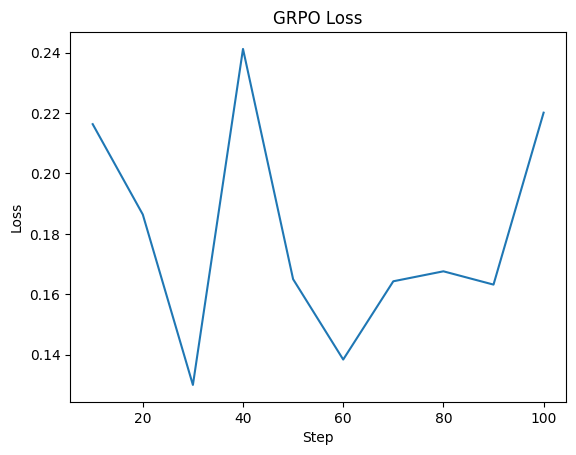

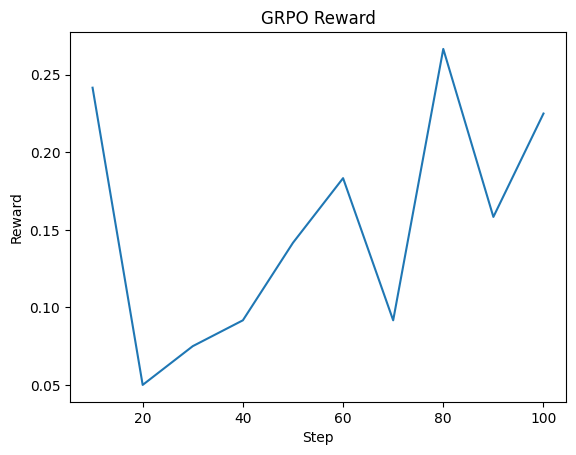

Available Logged Keys:


,Metric
0,loss
1,grad_norm
2,learning_rate
3,rewards/xmlcount_reward_func
4,rewards/soft_format_reward_func
5,rewards/strict_format_reward_func
6,rewards/int_reward_func
7,rewards/correctness_reward_func
8,reward
9,reward_std


In [12]:
# -----------------------------
# 8) Extract & display GRPO metrics
# -----------------------------
grpo_history = pd.DataFrame(grpo_trainer.state.log_history)
print("GRPO Logged Metrics (first & last 5 rows):")
display(grpo_history[["step", "loss", "reward", "learning_rate"]].head(5))
display(grpo_history[["step", "loss", "reward", "learning_rate"]].tail(5))

print("\nSample GRPO Generations:")
for ex in dataset.select(range(3))["prompt"]:
    inputs = tokenizer(ex, return_tensors="pt").to(peft_model.device)
    outputs = peft_model.generate(**inputs, max_length=500)
    print("Prompt:", ex)
    print("Generation:", tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("-" * 40)

# -----------------------------
# 9) Plot Training Curves
# -----------------------------
plt.figure()
if "loss" in grpo_history.columns:
    plt.plot(grpo_history["step"], grpo_history["loss"])
    plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("GRPO Loss")
    plt.show()
if "reward" in grpo_history.columns:
    plt.figure()
    plt.plot(grpo_history["step"], grpo_history["reward"])
    plt.xlabel("Step"); plt.ylabel("Reward"); plt.title("GRPO Reward")
    plt.show()

# -----------------------------
# 10) Show all logged metric keys
# -----------------------------
print("Available Logged Keys:")
display(pd.DataFrame(grpo_history.columns, columns=["Metric"]))